File ‘shape_predictor_68_face_landmarks.dat.bz2’ already there; not retrieving.
bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.
Please upload two images...


Saving epmEZVlfYhHXNsOzTdcA0hJ35Y5.jpg to epmEZVlfYhHXNsOzTdcA0hJ35Y5.jpg
Saving Bhagyashri_3_28d64e300c.jpg to Bhagyashri_3_28d64e300c (1).jpg
Processing first face swap...


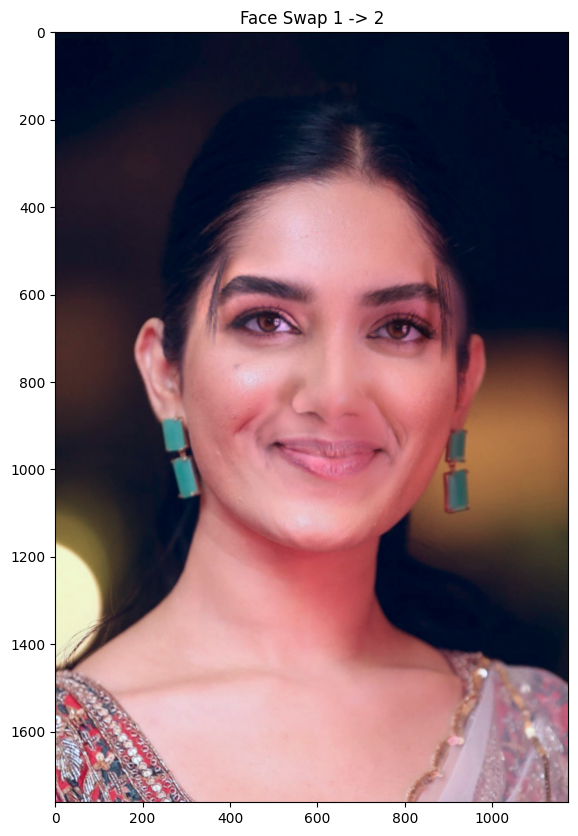

Processing second face swap...


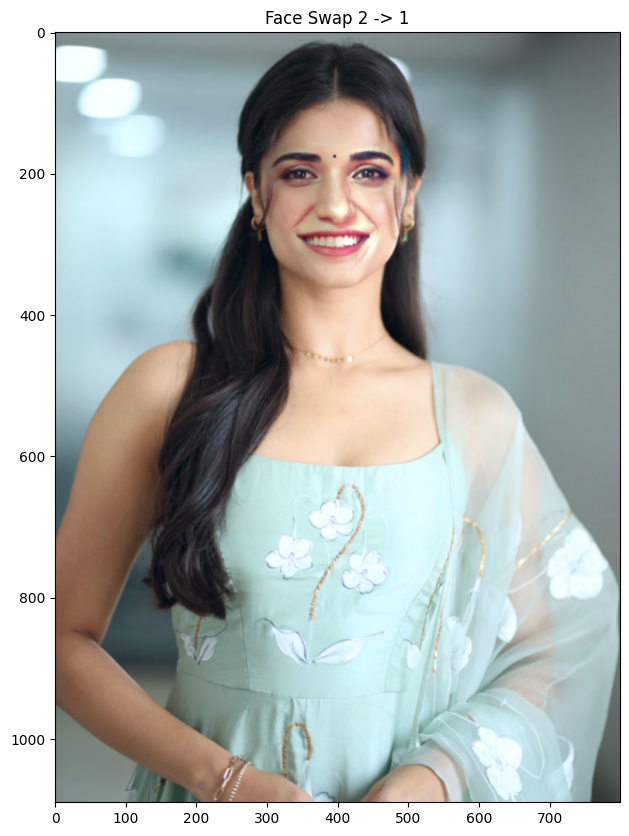

In [7]:
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

# Define a function to display images
def imshow(title="Image", image=None, size=10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w / h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

# Download the shape predictor model
!wget -nc http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

# Constants and paths
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1
FEATHER_AMOUNT = 15
COLOUR_CORRECT_BLUR_FRAC = 0.75

# Facial landmark indices
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))

ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Initialize detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

def get_landmarks(im):
    rects = detector(im, 1)
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces
    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])

def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    im = np.zeros(im.shape[:2], dtype=np.float64)
    for group in OVERLAY_POINTS:
        draw_convex_hull(im, landmarks[group], color=1)
    im = np.array([im, im, im]).transpose((1, 2, 0))
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT*2+1, FEATHER_AMOUNT*2+1), 0) > 0) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT*2+1, FEATHER_AMOUNT*2+1), 0)
    return im

def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = (U * Vt).T
    return np.vstack([np.hstack(((s2 / s1) * R,
                                c2.T - (s2 / s1) * R * c1.T)),
                      np.matrix([0., 0., 1.])])

def read_im_and_landmarks(image):
    im = image
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                        im.shape[0] * SCALE_FACTOR))
    s = get_landmarks(im)
    return im, s

def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

def preprocess_image(image):
    # Remove blue channel noise
    b, g, r = cv2.split(image)
    b = cv2.medianBlur(b, 3)
    return cv2.merge([b, g, r])

def balance_colors(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    b = cv2.subtract(b, np.mean(b.reshape(-1)) - 128)
    return cv2.cvtColor(cv2.merge([l, a, b]), cv2.COLOR_LAB2BGR)

def improved_color_correction(im1, im2, landmarks1):
    blur_amount = int(COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
        np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
        np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0)))
    if blur_amount % 2 == 0:
        blur_amount += 1

    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid division by zero
    im2_blur = np.where(im2_blur < 1.0, 1.0, im2_blur)

    result = (im2.astype(np.float64) * im1_blur.astype(np.float64) /
             im2_blur.astype(np.float64))

    # Normalize results
    result = np.clip(result, 0, 255)
    return result

def improved_face_swap(image1, image2):
    # Preprocess images
    image1 = preprocess_image(image1)
    image2 = preprocess_image(image2)

    # Color balance
    image1 = balance_colors(image1)
    image2 = balance_colors(image2)

    # Get landmarks and transform
    im1, landmarks1 = read_im_and_landmarks(image1)
    im2, landmarks2 = read_im_and_landmarks(image2)

    # Get transformation matrix
    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                 landmarks2[ALIGN_POINTS])

    # Create masks
    mask = get_face_mask(im2, landmarks2)
    warped_mask = warp_im(mask, M, im1.shape)
    combined_mask = np.max([get_face_mask(im1, landmarks1), warped_mask],
                          axis=0)

    # Warp and blend
    warped_im2 = warp_im(im2, M, im1.shape)
    warped_corrected_im2 = improved_color_correction(im1, warped_im2, landmarks1)

    # Smooth blending
    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

    # Post-processing
    output_im = cv2.GaussianBlur(output_im, (3, 3), 0)
    output_im = np.uint8(np.clip(output_im, 0, 255))

    return output_im

# Main execution
def main():
    # Upload images
    print("Please upload two images...")
    uploaded = files.upload()
    image_files = list(uploaded.keys())

    if len(image_files) < 2:
        print("Please upload at least two images.")
        return

    # Read images
    image1 = cv2.imread(image_files[0])
    image2 = cv2.imread(image_files[1])

    try:
        # Perform face swap in both directions
        print("Processing first face swap...")
        swapped1 = improved_face_swap(image1, image2)
        imshow('Face Swap 1 -> 2', swapped1)

        print("Processing second face swap...")
        swapped2 = improved_face_swap(image2, image1)
        imshow('Face Swap 2 -> 1', swapped2)

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        print("Please make sure both images contain clear, detectable faces.")

if __name__ == "__main__":
      main()